## Week 13 section: t-SNE 
### Sid Raju
based heavily on notes from Irina Shlosman (2019)

### 1. *Playing with dimensions* - which tool to pick...

We have seen many times, at this point, instances of biological datasets that are multi-dimensional. With RNA-seq data, specifically, we expect to be operating with numerous samples (e.g. single cells, tissue samples etc), each of which has several thousands of genes whose expression we would like to probe. These kinds of experiments give us $N \times M$-dimensional matrices, where $N$ is the number of samples, and $M$ is the number of genes, or, equivalently, the dimensionality of the space in which each sample resides. This picture is further complicated if we decide to assess other parameters - e.g. the biological sex of the specimen, WT vs mutant variation, or different experimental conditions. One of the ways to make sense of such data - and visualize the results - is to recast it in a fewer number of dimensions, most frequently in 2D. 

---

As Sean outlined in the lecture, there are many approaches to dimensionality reduction, and one of them we covered last week - principal components analysis (PCA). PCA proved to be very powerful on Watson's dataset, yielding nice clustering of cells that reproduced true biological subtypes. In that case, there were only 2 PCs that contributed in a significant way to the variance of the data, so we were able to denoise the data and plot it in 2 dimensions. 


Here is an illustration (that you might have seen before) that summarizes this process for a 3D dataset:

![pca_3D](http://mcb112.org/w13/pca_3D.png)
**Figure 1 **


We can imagine scenarios, however, where PCA would fail to identify clusters correctly - for instance, if there were more than 2 PCs with significant variances. 

Thinking of this problem in geometric terms, we would expect to encounter issues with PCA if we had an extra cluster of cells above the "plane" of maximum variance in which the remaining clusters can be best separated (as in **Figure 1**). If we were to project this modified dataset into 2D, we'd end up with considerable overlap between clusters that, in reality, are distinct.

In such cases - and we can definitely think of more complex geometries that might be a challenge for PCA (**Figure 2**) - 


![t-SNE 3D image](http://mcb112.org/w13/tSNE_original.png)
**Figure 2**

t-SNE (t-Distributed Stochastic Neighbor Embedding) becomes particularly useful, since it does not rely on *global* structure to embed points into 2D, but rather on their *local* structure. 

Here is the result of t-SNE analysis (**Figure 3**) of the original structure shown above with perplexity = 30. 

![t-SNE 2D reconstruction](http://mcb112.org/w13/tSNE_2D.png)
**Figure 3**


Very beautiful! These illustrations are taken from the [article that Sean references](https://distill.pub/2016/misread-tsne/) in his lecture notes. I highly recommend going online and playing with their examples - they helped me develop some intuition for how to interpret t-SNE plots.

For a recent, and ridiculously impressive, application check out [Cao et al 2020](https://science.sciencemag.org/content/370/6518/eaba7721), where the authors profiled ~4 million individual human fetal cells from 15 different organs and multiple time points by their gene expression and chromatin accessibility values, visualizing them in 2D with a similar method (**Figure 4**). A veritable "atlas" of human development.

![Cao](https://science.sciencemag.org/content/sci/370/6518/eaba7721/F2.large.jpg)

**Figure 4**

### 2. *Review the conceptual basis for t-SNE* 

t-SNE belongs to a family of nearest neighbor algorithms (see my favorite source Wiki for [more](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)) and captures local structure by defining neighbor relationships between the high-dimensional points in the dataset.

For each point $i$ which resides in $M$-dimensional space with coordinates {$x_{i1}...x_{im}$}, we can draw a spherical gaussian, speficied by a variance $\sigma_i$, which will define the probability that any point $j$ in the vicinity is its neighbor.

The euclidean distance between the two points is given by 

$$d_{ij} = ||x_i-x_j||$$

Note: We do not *choose* this value; it is given to us by the input data and never changes.

The conditional probability that $j$ is $i$'s neighbor is

$$p_{j|i} = \frac{\exp(\frac{-d_{ij}^2}{2\sigma_i^2})}{\sum_k\exp(\frac{-d_{ik}^2}{2\sigma_i^2})}$$

You can think of $d_{ij}$ as an *intrinsic* quality of the data, and $\sigma_i$ as a *choice* we make about how many neighbors we want our points to have. Loosely speaking, even if a potential neighbor is "far away", we can still make them a neighbor by increasing $\sigma_i$; conversely, even if a potential neighbor is "pretty close", we can still make them an outsider by decreasing $\sigma_i$. $\sigma_i$ is kind of like point i's "extraversion" in the parlance of the [Big 5 personality traits](https://en.wikipedia.org/wiki/Big_Five_personality_traits#Extraversion). We'll do this more formally in a bit.

Finally, for our final t-SNE computations, we calculate

$$P_{ij} = \frac{p_{j|i} + p_{i|j}}{2N}$$

As expected, the larger the chosen value of sigma, the greater the number of points that that will fall within the sphere and be counted as "neighbors". Conversely, the farther the point is from the center of the Gaussian, the less likely it is to be a neighbor. 

In t-SNE, we *choose* sigma values for each point such that the *perplexity*, which we can think of as the *effective* number of neighbors, is the same for all points. As a result, for points that are within a densely populated clusters, the sigma will be small, shrinking their spherical gaussians, whereas for points in sparse regions, the sigma will be larger to capture the desired neighbors.

---

**Question**: What does that tell us about intepreting cluster sizes in t-SNE?


**Question**: What about inter-cluster distances?


---

Thus, we can describe the original M-dimensional space of our N samples by an $N \times N$ matrix of conditions probabilities that define all the inter-point relationships. 

*The point of t-SNE, in layman's terms, is then to find a 2D representation that would capture as closely as possible these relationships*. 

**What do we mean by this mathematically?**

We would like to find such coordinates {${y_1...y_N}$} in 2D space that the probabity distribution function $Q_{ij}$ that describes the relationship of all the points in this 2-dimensional space matches as closely as possible the original M-dimensional $P_{ij}$. 

$$ q_{ij} = \frac { \left( 1 + \lVert y_i - y_j \rVert^2 \right)^{-1} } { \sum_{k \neq l} \left( 1 + \lVert y_k - y_l \rVert^2 \right)^{-1} } $$

Note: The difference in this t-SNE $q_{ij}$ vs. the SNE $q_{ij}$ is that the t-SNE version assumes a *heavy-tailed distribution*, alleviating the "crowding problem" endemic in SNE by assigning higher weights to points further away.

We can quantify the degree of similarity (or, rather difference) between these two probabilities with the so-called Kullback-Leibler divergence:

$$ D_{KL}(P||Q) = \sum_i\sum_j p_{ij}\log(\frac{p_{ij}}{q_{ij}})$$

Note: $D_{KL}(P||Q)$ will *always* be positive. You can take my word for it, or read about the [Kraft-McMillan inequality](https://en.wikipedia.org/wiki/Kraft%E2%80%93McMillan_inequality) and convince yourself.

When $p_{ij} = q_{ij}$, the logarithm term goes to 0, and the distance reaches its minimum. 

Our goal, therefore, is to find optimals parameters ${y_1...y_N}$ that minimize the Kullback-Leibler divergence.

We have tackled a number of optimization problems before, so, conceptually, we should be all set to take on this one. The hurdle in this particular case is setting up all the inputs to pass on to the optimizer. Just to be explicit, there are two separate optimization steps in t-SNE: 1) Choose $\sigma_i$'s to achieve desired perplexity and 2) Choose 2D embeddings to minimize $D_{KL}(P||Q)$. 

So let's talk about how to do that.

### 3. * The gruesome details* - setting up input for optimize.minimize

### 1. Calculate the true probability matrix:

The target matrix is $P_{ij}$, an $N\times N$ matrix that we will generate from the observed counts.

For that we need to 
- precompute the distance matrix $D_{ij}$ of dimensions $N \times N$ 
- calculate an array of sigma values {$\sigma_1...\sigma_N$} of size $1\times N$

---

**Calculate the distance matrix**

The distance matrix should be relatively straightforward. I would create a separate function and precalculate the matrix so that I can use it as input for later functions. 

    def calculate_dist(X):
        
        # calculate the distance between each pair of points in the dataset, storing in a matrix D 
        # (hint: use np.linalg.norm)
        
        return D
    
---

**Calculate sigma (first of 2 optimizations in t-SNE algorithm)**

Calculating sigma for each point $i$ is a little bit more involved. As Sean outlined in the lecture notes, we can easily determine the value of a perplexity, *given* a sigma. The Shannon entropy is given by:

$$ H_i = - \sum_j p_{j \mid i} \log_2 p_{j \mid i} $$

where sigma lurks into the equation through the $p_{j|i}$ term

And perplexity is just $$ \mathrm{Perplexity} = 2^H$$

However, we would like to carry out the reverse process - given a perplexity value, find a sigma that satisfies it, and for that purpose, we will turn to `scipy.optimize.bisect()`.

The basic idea behind this is that we can recast the problem of finding a sigma as a root-finding problem where we find a sigma such that $f(\sigma) = 0$ by passing our function to `scipy.optimize.bisect()`. 

In our particular case, the function for which we want to find the root is $\mathrm{Perplexity_{true}}-\mathrm{Perplexity_{estimated}}$, where perplexity itself is a function of $\sigma$.


Our function, therefore, should look something like this:



    def perplexity_diff(sigma_i, D_i, perplexity_true):
    
        # calculate sigma_i
        
        # normalize p_ji 
        
        # calculate the entropy 
        
        # calculate estimated perplexity 
        
        # calculate difference between perplexity_true and estimated
        
        return difference
        

We can then pass on that difference to `scipy.optimize.bisect()` specifying boundary values (a,b), and making sure that the $D_i$ array is flattened. 


---

**A brief interlude on how to use scipy.optimize.bisect()**

Just to give you a hint, here is how you would do that for an analogous problem - finding the root of equation $$\exp(10^{-3x})-50 = 0$$

Let's imagine that I did not google this equation and did not look at the plot of the function, so that I don't have a good guess for the upper and lower bounds. What I *do* know, however, is that 

1. This is a monotonically increasing function
2. The root is > 1, since $$ e^{0.001x} = 50$$

If we take $p = 0.001x$, we can rewrite this as follows: 

$$e^{p} > e$$ which demands that $p > 1$, which means that $x >> 1$ 

So I can make a reasonable guess for the upper and lower bounds, and apply the principles I outlined above to find the root of this equation! 

In [2]:
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt

def func(x):
        return np.exp(1e-3*x)-50

lower_bound = 2 # some random number above one

while func(lower_bound) > 0: # while were not below 0
    lower_bound /= 2 # decrease function. 
    # since the update is multiplicative, it won't go below 0
    
upper_bound = lower_bound # set the upper bound initially
# to the same value

while func(upper_bound) < 0:
    upper_bound *= 2 # update multiplicatively

print('upper bound: {}'.format(upper_bound))
print('lower bound: {}'.format(lower_bound))
print(optimize.bisect(func, lower_bound, upper_bound))

upper bound: 4096
lower bound: 2
3912.0230054281465


Let's check that we got the right answer: 

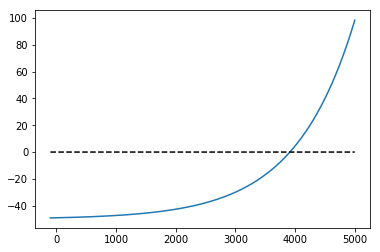

In [2]:
X = np.arange(-100,5000)
plt.plot(X, np.exp(0.001*X)-50)
plt.plot(X, np.zeros(len(X)),'k--')

Looks like we got the intercept!

---

**Calculate the probability matrix**

OK, now that we know how to obtain sigma values for all of our points, we are ready to set up the $P_{ij}$ matrix. 


We know that this matrix is the average of conditional probability matrices: $$P_{ij} = \frac{P_{i|j}p_j+P_{j|i}p_i}{2}$$

Since we assume that all points are equiprobable, i.e. $$p_j = p_i = \frac{1}{N}$$

The equation simplifies to $$P_{ij} = \frac{P_{i|j}+P_{j|i}}{2N}$$

So I'd first set up a function to calculate conditional probabilities, and then combine them to give the final symmetric probability distribution.

Just as a reminder,

$$p_{j|i} = \frac{\exp(\frac{-d_{ij}^2}{2\sigma_i^2})}{\sum_k\exp(\frac{-d_{ik}^2}{2\sigma_i^2})}$$

    def calculate_conditional(X, sigma, D):
        # for each pair of non-identical points:
            # calculate the numerator of P_ji from the precomputed matrix entries and normalize
        #set all diagonal entries of the conditional matrix to 0
                    
        return P_j|i


Finally, compute the symmetrized $P_{ji}$ given the two conditional probabilities. Phew, we're done with the initial set up!

---

### 2. Initialization and $Q_{ij}$ calculation

Now what's left is generating random guesses for $y_1...y_N$ in the 2D space - Sean recommended using a very small gaussian. 
    
    mu = 0
    sigma = 1e-4
    Y = np.random.normal(mu,sigma, (len(X),2)) 
    Y is of dimensions Nx2
    
We will do that for each independent run of the `scipy.optimize.minimize` routine.

And computing $Q_{ij}$ matrix, which should be of the same dimensions as $P_{ij}$ matrix, i.e. $N\times N$. I will leave you to figure it out - there shouldn't be any unpleasant surprises there... :)

---

### 3. KL divergence and the gradient (second of 2 optimizations in t-SNE algorithm)

The final piece is calculating the KL divergence (that we will use to monitor the convergence of the algorithm) and the gradient, which we have to pass on to `scipy.optimize.minimize`. 

Sean recommended combining calculations of the KL divergence and the gradient, since they both involve calculating the $Q_{ij}$ matrix, and it's nice not to have to do it twice. 

Here's a suggested framework for KL calculations:


    def KL_dist(Y, Pij):
        
        # for each pair of points i and j: 
            # Calculate gradient for (i,j) and sum over all j's:
            # Calculate KL for each pair (i,) and sum over all i's and j's, taking care to avoid the zero entries
        
        # Scale the gradient 
        # Return the resulting KL and the gradient
        return KL, gradient
        
---

At this point, you should be all set to carry out t-SNE analysis on the dataset. Make sure to run the analysis multiple times from random starting positions, because t-SNE, as Sean talked about in the lecture, is prone to getting stuck in local minima!

Something to consider:

Which parameters (aka perplexity values) to test on each of the datasets? 

What do you expect your plots to look like for different perplexity values?

### 4. *Canned t-SNE* - let's perplex a bit

In [71]:
# Borrowing data from HW11
import pandas as pd
df = pd.read_table('http://mcb112.org/w11/w11-data.tbl', delim_whitespace=True)
data_use = df.values
logdata = np.log(data_use.astype(int))

Let's run t-SNE on previous week's dataset, and see how the algorithm does. Painful to see this one-liner and to think of the hours that will have to be spent to implement what already exists, isn't it?

Let's console ourselves with the thought that maybe we'll learn something useful in the process.

In [72]:
from sklearn.manifold import TSNE

perplexities = [5,10,30,50,100,200]
Y = []
X = logdata

for perp in perplexities:
    print('fitting model perplexity = {}'.format(perp))
    Y.append( TSNE(perplexity=perp).fit_transform(X) )

fitting model perplexity = 5
fitting model perplexity = 10
fitting model perplexity = 30
fitting model perplexity = 50
fitting model perplexity = 100
fitting model perplexity = 200


In [73]:
# load cluster labels determined by k-means
labels = np.loadtxt('http://mcb112.org/w13/labels_best.txt')

Now let's plot the results of t-SNE analysis for different perplexity values and coloring the points by their "true" clusters.

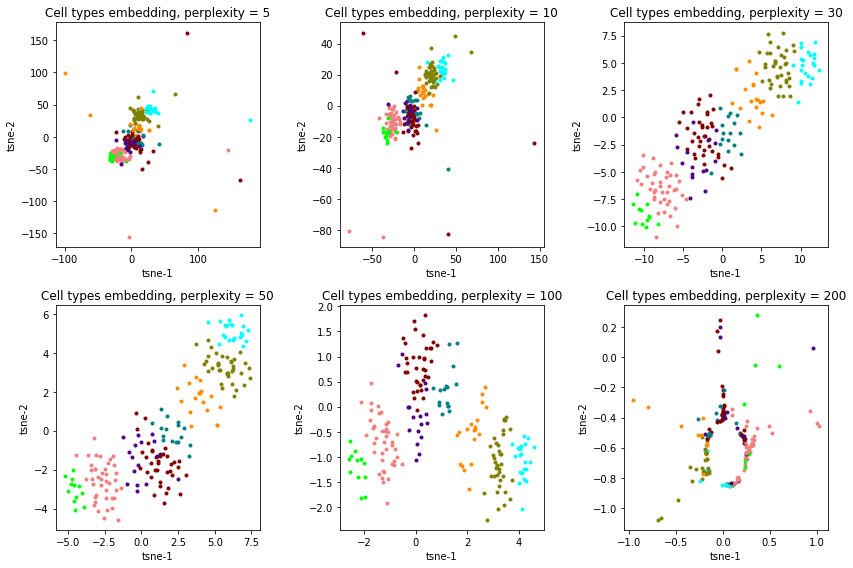

In [74]:
%matplotlib inline
fig, axs = plt.subplots(2,int(len(perplexities)/2), figsize=(12, 8))
axs = axs.ravel()
k=8

colormap = ['darkorange',    'lightcoral',  'maroon', 'olive',
         'indigo', 'teal', 'cyan',    'lime']

for i in range(len(perplexities)):
    for j in range(len(logdata)):
        axs[i].plot(Y[i][j,0], Y[i][j,1], Linestyle="", Marker='.',color=colormap[int(labels[j])])
        axs[i].set_xlabel('tsne-1')
        axs[i].set_ylabel('tsne-2')
        axs[i].set_title('Cell types embedding, perplexity = {}'.format(perplexities[i]))

plt.tight_layout()

Hmm, this is clearly a difficult dataset for t-SNE. There is a perplexity value ~ 100, however, at which it seems to do relatively reasonably. Interestingly, above and below this value the prediction looks quite terrible. The outcome of the analysis is clearly very sensitive to the chosen perplexity value... We might have thought, perhaps naively, that the optimal perplexity value would be in the same range as as the approximate size of the cluster: in our case, ~200/8 = 25 ish. However, perplexity values 10-50 result in sub-optimal separation, and we see better separation at 100. 

---

OK, let's investigate one other property of t-SNE analysis - and that is the relationship between true cluster sizes and inter-cluster distances, and the t-SNE output.

For that purpose, we can choose a simpler dataset (our 2D test dataset from HW5), where we know that cells cluster nicely in log-log space. 

In [75]:
df = pd.read_table('http://mcb112.org/w05/w05-data.tbl', delim_whitespace=True)
data2D = df.iloc[:,2:4]
log2Ddata = np.log(data2D)
ctype = df.iloc[:, 1]

In [76]:
# Run t-SNE
Y2D = []
X2D = log2Ddata

for perp in perplexities:
    print('fitting model perplexity = {}'.format(perp))
    Y2D.append( TSNE(perplexity=perp).fit_transform(X2D) )

fitting model perplexity = 5
fitting model perplexity = 10
fitting model perplexity = 30
fitting model perplexity = 50
fitting model perplexity = 100
fitting model perplexity = 200


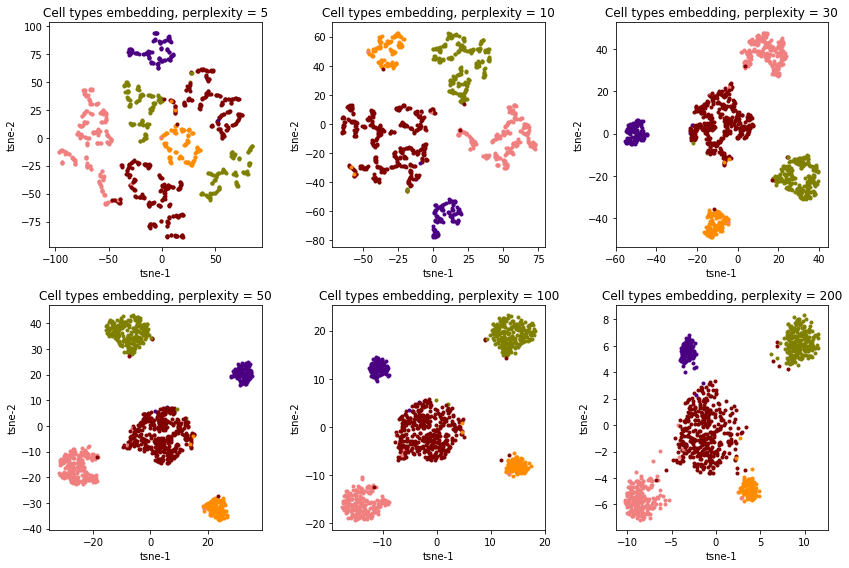

In [77]:
fig, axs = plt.subplots(2,int(len(perplexities)/2), figsize=(12, 8))
axs = axs.ravel()

colormap = ['darkorange',    'lightcoral',  'maroon', 'olive',
         'indigo', 'teal', 'cyan',    'lime']

for i in range(len(perplexities)):
    for j in range(len(log2Ddata)):
        axs[i].plot(Y2D[i][j,0], Y2D[i][j,1], Linestyle="", Marker='.',color=colormap[int(ctype[j])])
        axs[i].set_xlabel('tsne-1')
        axs[i].set_ylabel('tsne-2')
        axs[i].set_title('Cell types embedding, perplexity = {}'.format(perplexities[i]))

plt.tight_layout()



Remembering what the true clusters look like in log-log space (this figure is taken directly from your HW5), what can we say about t-SNE's ability to reproduce true cluster sizes and inter-cluster distances?


![Wiggins' clusters](http://mcb112.org/w05/w05-Figure2.png)
